In [3]:
import os
from pathlib import Path

import pandas as pd
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt


from model_deployment.prove import Summary, StraightLineSummary

from evaluation.eval_analysis import (
    EvalDesc,
    EvalData,
    load_evals,
    find_mutual_proofs,
    PlotPoint,
    ProofPair,
    count_total_successes,
    get_two_eval_subsets,
    get_three_eval_subets,
    a_beats_b_generator,
)

In [4]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling": 
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")
    


In [5]:
EVALS = [
    ## Ablations on Rango
    # EvalDesc("tfidf proof; tfidf prem", "proof-prem-final"),
    # EvalDesc("tfidf proof; select prem", "tfidf-proof-select-proj-thm-prem-final"),

    # EvalDesc("tfidf proof; bm25 prem", "tfidf-proof-bm25-proj-thm-prem-final"),
    # EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("codebert proof; tfidf prem", "codebert-proof-tfidf-proj-thm-prem-final")

    ## Ablations on Rango Bm25
    #EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("bm25 proof; bm25 prem", "bm25-proof-bm25-proj-thm-prem-final"),
    # EvalDesc("bm25 proof; select prem", "bm25-proof-select-proj-thm-prem-final"),
    # EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),
    EvalDesc("bm25 proof; rerank prem", "bm25-proof-rerank-tfidf-proj-thm-prem-final"),

    ## First Step Retrieval 
    # EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("bm25 proof (first step); tfidf prem", "bm25-first-step-proof-tfidf-proj-thm-prem-final"),

    ## Token Masking
    # EvalDesc("No mask", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("Masked Proof State", "bm25-proof-tfidf-proj-thm-prem-final-mask-state"),
    # EvalDesc("Masked Proof Script", "bm25-proof-tfidf-proj-thm-prem-final-mask-script"),
    # EvalDesc("Masked Retrieved Proofs", "bm25-proof-tfidf-proj-thm-prem-final-mask-proof"),
    # EvalDesc("Masked Retrieved Premises", "bm25-proof-tfidf-proj-thm-prem-final-mask-premise"),

    ## Multiple runs of Select 
    # EvalDesc("tfidf proof; select prem 1", "tfidf-proof-select-proj-thm-prem-final"),
    # EvalDesc("tfidf proof; select prem 2", "tfidf-proof-select-proj-thm-prem-final-2"),
    # EvalDesc("tfidf proof; select prem 3", "tfidf-proof-select-proj-thm-prem-final-3"),

    ## BM25 vs TFIDF
    # EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("tfidf proof; tfidf prem", "tfidf-proof-tfidf-proj-thm-prem-final"),

    ## Ablations on Retrieval
    # EvalDesc("Rango", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("Rango w/o Proofs", "tfidf-proj-thm-prem-final"),
    # EvalDesc("Rango w/o Retrieval", "basic-ablation-final"),
    # EvalDesc("Rango w/o Premises", "bm25-proof-final"),
    # EvalDesc("Rango w/ Prefix Retrieval", "prefix-final"),

    ## Previous Proofs
    # EvalDesc("Rango", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("Directly Trying Previous Proofs", "bm25-prev-proof-final"),

    # Random Intersect Comparison
    # EvalDesc("Inter-project", "bm25-proof-tfidf-proj-thm-prem-intersect-final"),
    # EvalDesc("Inter-project; w/o proofs", "tfidf-proj-thm-prem-intersect-final"),
    # EvalDesc("Inter-project; w/o premises", "bm25-proof-intersect-final"),
    # EvalDesc("Inter-project; w/ Prefix Retrieval", "prefix-intersect-final"),
    # EvalDesc("Inter-project; w/o retrieval", "basic-ablation-intersect-final"),

    # EvalDesc("Inter-file", "bm25-proof-tfidf-proj-thm-prem-intersect-random"),
    # EvalDesc("Inter-file; w/o proofs", "tfidf-proj-thm-prem-intersect-random"),
    # EvalDesc("Inter-file; w/o premises", "bm25-proof-intersect-random"),
    # EvalDesc("Inter-file; w/ Prefix Retrieval", "prefix-intersect-random"),
    # EvalDesc("Inter-file; w/o retrieval", "basic-ablation-intersect-random"),

    # # Cutoff
    # EvalDesc("Rango 8.18 Cutoff", "bm25-proof-tfidf-proj-thm-prem-cutoff-8.18"),

    # # GPT
    # EvalDesc("Gpt 4o", "gpt-4o-8.18-test"),
    # EvalDesc("Gpt 4o mini", "gpt-4o-mini-8.18-test"),
    # EvalDesc("Gpt o1", "gpt-o1-8.18-test"),
    # EvalDesc("Gpt o1 mini", "gpt-o1-mini-8.18-test"),

]
RESULTS_LOC = Path("evaluations/eval-results")
raw_evals = load_evals(EVALS, RESULTS_LOC)

In [6]:
[len(r.results) for r in raw_evals]

[500, 12077, 500]

## Proof Count (Sanity Check)

In [7]:
mutual_proofs = find_mutual_proofs(raw_evals, include_errors=True)
evals = [e.filter_to_proofs(mutual_proofs) for e in raw_evals]
assert all(len(e.results) == len(mutual_proofs) for e in evals)
print("Mutual proofs:", len(mutual_proofs))

Mutual proofs: 500


In [8]:
len(mutual_proofs)

500

## Successes

In [9]:
rows: list[tuple[int, int, float, float]] = []
idx: list[str] = []
for e in evals:
    n_successes = len(e.get_successful_searches())
    n_attempts = len(e.results)
    p = n_successes / n_attempts
    cost = e.get_total_cost()
    moe = 1.96 * (p * (1 - p) / n_attempts) ** 0.5
    rows.append((n_successes, n_attempts, n_successes / n_attempts, cost))
    idx.append(e.alias)
pd.DataFrame(rows, columns=["Successes", "Attempts", "Success Rate", "Cost"], index=idx)



,Successes,Attempts,Success Rate,Cost
tfidf proof; bm25 prem,153,500,0.306,0
bm25 proof; tfidf prem,164,500,0.328,0
codebert proof; tfidf prem,118,500,0.236,0


In [10]:
(149 - 69) / 69

1.1594202898550725

## Count Error Fraction

In [11]:
for e in evals:
    print(e.alias, e.get_error_fraction())

tfidf proof; bm25 prem 0.008
bm25 proof; tfidf prem 0.002
codebert proof; tfidf prem 0.004


## Proofs over Time

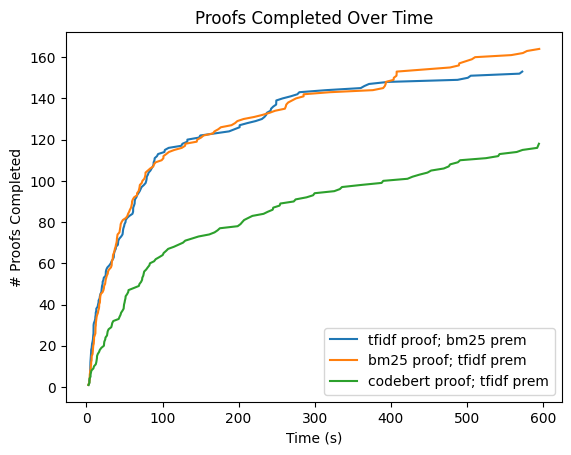

In [12]:
def plot_times(es: list[EvalData]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Time")
    ax.legend(loc="lower right")


plot_times(evals)

In [13]:
# def get_last_success(e: EvalData) -> float:
#     successes = e.get_successful_searches()
#     return max(successes, key=lambda s: s.search_time).search_time

# [(e.alias, get_last_success(e)) for e in evals]



# Proofs Completed over Model Time

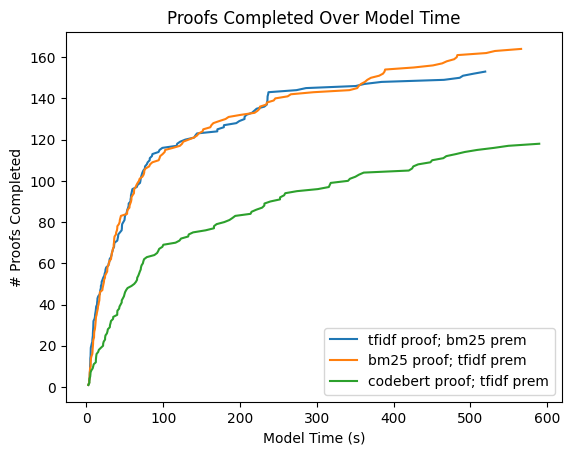

In [14]:
def plot_model_times(es: list[EvalData]):
    times = [e.get_model_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Model Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Model Time")
    ax.legend(loc="lower right")


plot_model_times(evals)

## Proofs over Attempts

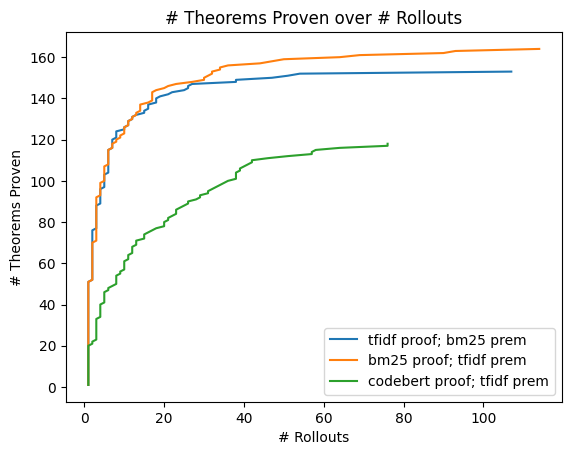

In [15]:
def plot_attempts(es: list[EvalData]):
    attempts = [e.get_attempts_points() for e in es]
    fig, ax = plt.subplots()
    for e, attempt_list in zip(es, attempts):
        xs = [t.x for t in attempt_list]
        ys = [t.y for t in attempt_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("# Rollouts")
    ax.set_ylabel("# Theorems Proven")
    ax.set_title("# Theorems Proven over # Rollouts")
    ax.legend(loc="lower right")


plot_attempts(evals)

## Overlap Comparison

In [16]:
print("Total # Theorems Found: ", count_total_successes(evals))

Total # Theorems Found:  184


AssertionError: 

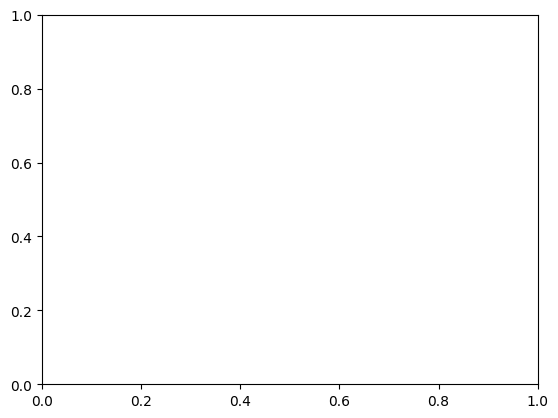

In [17]:
def compare_two(es: list[EvalData], e1_alias: str, e2_alias: str):
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
          set_labels=(e1_alias, e2_alias), ax=ax)


def compare_three(es: list[EvalData], e1_alias: str, e2_alias: str, e3_alias: str):
    fig, ax = plt.subplots()
    subsets = get_three_eval_subets(es, e1_alias, e2_alias, e3_alias)
    venn3((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two),
              len(subsets.three_only), len(subsets.one_three), len(subsets.two_three),
              len(subsets.one_two_three)),
             set_labels=(e1_alias, e2_alias, e3_alias), ax=ax)

compare_three(evals, "Bm25 Proofs + Premises", "Proofs Bm25", "Basic")

In [ ]:
subsets = get_two_eval_subsets(evals, "Basic", "Proofs + Premises")

AssertionError: 

In [ ]:
sorted([p for p in subsets.two_only if "AbsInt" in str(p.file_name)], key= lambda p: p.file_name)

[ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/MenhirLib/Interpreter_complete.v', theorem_id='start_goto-5'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/MenhirLib/Interpreter_complete.v', theorem_id='ptd_buffer_build_from_ptl-20'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/MenhirLib/Interpreter_complete.v', theorem_id='first_stable-1'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/Allocation.v', theorem_id='ge_lub_left-26'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/Asmgenproof0.v', theorem_id='exec_straight_opt_right-66'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/Inlining.v', theorem_id='Anon-6'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/Locations.v', theorem_id='disjoint_cons_right-13'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/RTLgenproof.v', theorem_id='transl_exprlis

# Inspect Individual Results

In [ ]:
A = "Local Basic"
B = "Slurm Basic"
better_gen = a_beats_b_generator(evals, A, B)

In [ ]:
def display_diff(p: ProofPair, e1_alias: str, e2_alias: str, s1: Summary, s2: Summary):
    print(f"{e1_alias} beat {e2_alias} on {p.theorem_name} from {p.file_name}")
    assert s1.success == True
    if isinstance(s1, StraightLineSummary):
        assert s1.attempts is not None
        print(f">>>>> {e1_alias} found a proof in {s1.search_time} seconds ({s1.model_time} model seconds) and {len(s1.attempts)} attempts.")
    else:
        print(f">>>>> {e1_alias} found a proof in {s1.search_time} seconds ({s1.model_time} model seconds)")

    assert s1.proof is not None
    print(s1.proof)

    print()
    if s2.search_time is None:
        print(f"<<<<< {e2_alias} failed with an error.")
        return
    if isinstance(s2, StraightLineSummary):
        assert s2.attempts is not None
        print(f"<<<<< {e2_alias} failed after {s2.search_time} seconds ({s1.model_time} model seconds) and {len(s2.attempts)} attempts.")
        for a in s2.attempts: 
            print(a)
    else:
        print(f"<<<<< {e2_alias} failed after {s2.search_time} seconds ({s1.model_time} model seconds)")


In [ ]:
p, s1, s2 = next(better_gen)
display_diff(p, A, B, s1, s2)


AssertionError: 

# Itemized Summary

In [902]:

from dataclasses import dataclass 

@dataclass
class ResultThm:
    file: str
    theorem: str
    idx: int


columns = ["File", "Theorem", "Theorem #", "Success"]
result_dict: dict[str, pd.Series] = {}
for e in evals:
    e_index: list[tuple[str, str, str]] = []
    e_results: list[str] = []
    for r in e.results: 
        e_index.append((str(r.file), r.theorem, r.theorem_id))
        if r.success:
            e_results.append("Success")
        elif r.search_time is None:
            e_results.append("Error")
        else:
            e_results.append("Failure")
    result_dict[e.alias] = pd.Series(e_results, index=pd.MultiIndex.from_tuples(e_index, names=["File", "Theorem", "Theorem #"]))
df = pd.DataFrame(result_dict)



Rango 8.18 Cutoff  \
File                                               Theorem                                            Theorem #                                                          
raw-data/cutoff-eval-dataset/repos/Coq-BB5/Help... Lemma Str_app_assoc {A} (xs ys : list A) (zs : ... Str_app_assoc-10                                         Success   
                                                   Lemma positive_strong_induction : forall (P : p... positive_strong_induction-13                             Failure   
raw-data/cutoff-eval-dataset/repos/Coq-BB5/Skel... Lemma WF1_00 x xs: ~WF1 (x, xs ++ [0; 0]%nat).     WF1_00-75                                                  Error   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... #[global] Add Parametric Morphism : isOrdinal w... Add-76                                                   Failure   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Lemma subst1_satisfies_spec (x : ivar) (t : trm... subst1_satisfies_spec-88                                 Success   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Lemma equiv_hsubst_in_trm_implies_hsubst_trm_sa... equiv_hsubst_in_trm_implies_hsubst_trm_same-35           Failure   
                                                   Lemma embed_subst_trm (s : subst L) (t : trm L)... embed_subst_trm-87                                       Failure   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Theorem HilbertCalculus_sound (Gamma : ensemble... HilbertCalculus_sound-0                                  Failure   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Lemma ContradictionE_preserves (Gamma : ensembl... ContradictionE_preserves-2                               Success   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Lemma subst_frm_close_frm (n : nat) (s : subst ... subst_frm_close_frm-45                                     Error   
                                                   Lemma alpha_hyp (Gamma : ensemble (frm L)) (p :... alpha_hyp-25                                               Error   
                                                   #[local] Instance equiv_deductible_transitive :... Instance-38                                                Error   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Lemma Pre_umin_Dumin {s : nat} (EXISTENCE : exi... Pre_umin_Dumin-6                                         Failure   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Lemma lemma3_of_1_2_13 F (F_isFilter : isFilter... lemma3_of_1_2_13-33                                      Failure   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Corollary ScottContinuousMap_preserves_supremum... ScottContinuousMap_preserves_supremum-5                  Success   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Lemma supremum_of_monotonic_maps_isMonotonic {D... supremum_of_monotonic_maps_isMonotonic-2                 Failure   
                                                   Theorem KnasterTarski_1st (f : D -> D) (f_isMon... KnasterTarski_1st-4                                      Failure   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Theorem is_supremum_in_iff (phi : D -> Prop) (s... is_supremum_in_iff-31                                    Failure   
raw-data/cutoff-eval-dataset/repos/PnVRocqLib/t... Lemma mod_eq_elim (a1 : nat) (a2 : nat) (b : na... mod_eq_elim-20                                           Failure   
                                                   Lemma cpInv_rightInv (x : nat) (y : nat) : cp (... cpInv_rightInv-7                                         Failure   

                                                                                                                                                       Gpt 4o  \
File                                               Theorem                                            Theorem #                                                 
raw-data/cutoff-eval-dataset/repos/Coq-BB5/Help... Lemma Str_app_assoc {A} (xs ys : li

In [907]:
df.reset_index()["File"]

0     raw-data/cutoff-eval-dataset/repos/Coq-BB5/Hel...
1     raw-data/cutoff-eval-dataset/repos/Coq-BB5/Hel...
2     raw-data/cutoff-eval-dataset/repos/Coq-BB5/Ske...
3     raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
4     raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
5     raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
6     raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
7     raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
8     raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
9     raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
10    raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
11    raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
12    raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
13    raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
14    raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
15    raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
16    raw-data/cutoff-eval-dataset/repos/PnVRocqLib/...
17    raw-data/cutoff-eval-dataset/repos/PnVRocq

In [916]:


def clean_df(df: pd.DataFrame, file_prefix: str) -> pd.DataFrame:
    new_df = df.copy().reset_index()
    assert new_df["File"].apply(lambda x: x.startswith(file_prefix)).all()
    new_df["File"] = new_df["File"].apply(lambda x: x[len(file_prefix):])
    return new_df
clean = clean_df(df, "raw-data/cutoff-eval-dataset/repos/")
clean.to_csv("evaluations/stuff/gpt-2024-09-30.csv", index=False)

In [32]:
def print_attempts(e: EvalData, thm_id: str):
    print(e.alias)
    for r in e.results:
        if r.theorem_id == thm_id:
            if r.attempts is None:
                print("No attempts")
            for i, a in enumerate(r.attempts):
                print("===================")
                print(f"Attempt {i + 1}")
                print(a)
            if r.proof is not None:
                print("===============")
                print("Successful Proof: ")
                print(r.proof)
            return

for i in range(len(evals)):
    print("<><><><><><><><><><>")
    print_attempts(evals[i], "subst1_satisfies_spec-88")


<><><><><><><><><><>
Rango 8.18 Cutoff
Attempt 1

Proof.
  split.
Attempt 2

Proof.
  unfold subst1_spec.
Attempt 3

Proof.
  unfold subst1_spec, subst1.
Attempt 4

Proof. firstorder. unfold subst1_spec.
Attempt 5

Proof.
  unfold subst1_spec.
Attempt 6

Proof.
  unfold subst1_spec, subst1, subst1_uniquely_exists.
Attempt 7

Proof.
  unfold subst1; simpl.
  unfold subst1_uniquely_exists.
Attempt 8

Proof.
  intros SPEC_X.
Attempt 9

Proof. apply subs_s_t.
Attempt 10

Proof.
  unfold subst1_spec, subst1.
Attempt 11

Proof.
  unfold subst1. unfold funcomp.
Attempt 12

Proof.
  split.
Attempt 13

Proof.
  unfold subst1. simpl. intros.
  destruct (subst1_uniquely_exists x t p) as [p' [SUBST SUBST_RANK]]; simpl.
  exact SUBST.
Successful Proof: 
Lemma subst1_satisfies_spec (x : ivar) (t : trm L) (p : frm L) : subst1_spec x t p (subst1 x t p).
Proof.
  unfold subst1. simpl. intros.
  destruct (subst1_uniquely_exists x t p) as [p' [SUBST SUBST_RANK]]; simpl.
  exact SUBST.
Qed.
<><><><><><><>